<a href="https://colab.research.google.com/github/PabloJRW/TinyML-sineFunction/blob/main/TinyML_Sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 

In [39]:
np.random.seed(12)
tf.random.set_seed(12)

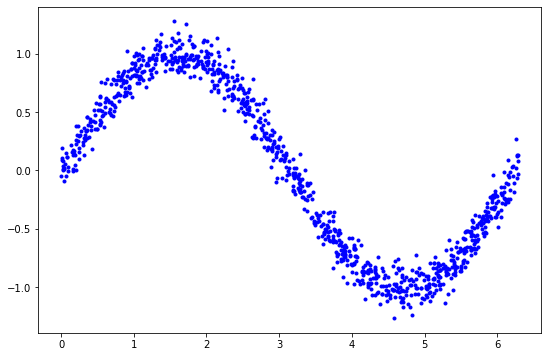

In [40]:

x_values = np.random.uniform(low=0, high=2*math.pi, size=1000)

# Shuffle the values

# Calculate the corresponding sine values
y_values = np.sin(x_values)
# Adding noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# 
plt.figure(figsize=(9,6))
plt.plot(x_values, y_values, 'b.')
plt.show()

In [41]:
# Splitting the data
train_size = int(0.6 * len(x_values))
test_size = int(0.2 * len(x_values) + train_size)

X_train, X_val, X_test = np.split(x_values, [train_size, test_size])
y_train, y_val, y_test = np.split(y_values, [train_size, test_size])

assert (X_train.size + X_val.size + X_test.size) == len(x_values)

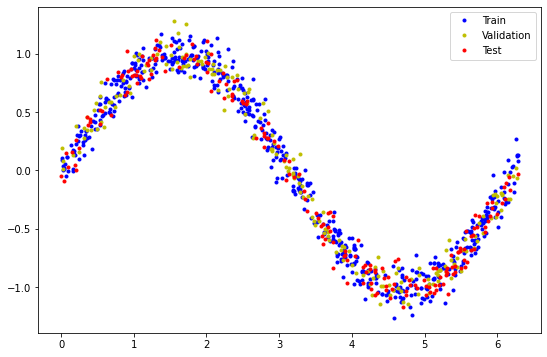

In [42]:
# Plot the data in each data set
plt.figure(figsize=(9,6))
plt.plot(X_train, y_train, 'b.', label='Train')
plt.plot(X_val, y_val, 'y.', label='Validation')
plt.plot(X_test, y_test, 'r.', label='Test')
plt.legend()
plt.show()

In [43]:
model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation='relu', input_shape=(1, )))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                32        
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [45]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_val, y_val))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 0.8584 - mae: 0.7935 - val_loss: 0.4564 - val_mae: 0.5490
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 0.3760 - mae: 0.5214 - val_loss: 0.3324 - val_mae: 0.4995
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.3157 - mae: 0.4868 - val_loss: 0.2936 - val_mae: 0.4738
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 0.2770 - mae: 0.4586 - val_loss: 0.2563 - val_mae: 0.4432
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.2468 - mae: 0.4344 - val_loss: 0.2339 - val_mae: 0.4179
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.2233 - mae: 0.4149 - val_loss: 0.2122 - val_mae: 0.3977
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 0.2075 - mae: 0.3987 - val_loss: 0.2009 - val_mae: 0.3916
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.1949 - m

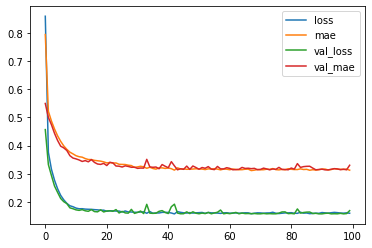

In [46]:
pd.DataFrame(history.history).plot()
plt.legend()
plt.show()

In [47]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model 
with open("sine_model.tflite", "wb") as f:
  f.write(tflite_model)

#Convert the model to Tensorflow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
  for value in X_test:
    yield [np.array(value, dtype=np.float32)]

converter.representative_dataset = representative_dataset_generator

# Convert the model
tflite_model = converter.convert()

# Save the optimized model 
with open("sine_model_quantized.tflite",  "wb") as fq:
  fq.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [48]:
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

sine_model_predictions = []
sine_model_quantized_predictions = []

for x_value in X_test:
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  sine_model.invoke()

  sine_model_predictions.append(
      sine_model.get_tensor(sine_model_output_index)[0])
  
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])

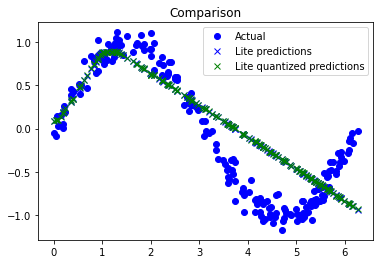

In [49]:
plt.clf()
plt.title("Comparison")
plt.plot(X_test, y_test, 'bo', label='Actual')
plt.plot(X_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(X_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()
